In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from freedom.toy_model import toy_model
import tensorflow as tf
from sklearn.model_selection import train_test_split
import dragoman as dm
import pickle
import os
from types import SimpleNamespace
%load_ext autoreload
%autoreload 2

In [2]:
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14 
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['legend.fontsize'] = 14

In [3]:
toy_experiment = toy_model.toy_experiment(detector_xs=np.linspace(-5, 5, 11), t_std=1)

In [4]:
example_x_src = 2.45
example_b_src = 1.1
example_N_src = 2.3

In [5]:
# generate one test event
test_event = toy_experiment.generate_event(x_src=example_x_src, b=example_b_src, N_src=example_N_src)

In [6]:
# Grid scan

g = dm.GridData(x=np.linspace(-5, 5, 100), b=np.linspace(-2, 2, 100))

g['dom_hit_term'] = np.empty(g.shape)
g['dom_charge_terms'] = np.empty(g.shape)
g['total_charge_hit_terms'] = np.empty(g.shape)
g['total_charge_terms'] = np.empty(g.shape)

for idx in np.ndindex(g.shape):
    hypo_x =  g['x'][idx]
    hypo_b =  g['b'][idx]
    hypo_t = 0
    hypo_N_src = example_N_src
    g['dom_hit_term'][idx] = -toy_experiment.dom_hit_term(test_event[1], hypo_x, hypo_b, 0)
    g['dom_charge_terms'][idx] = -toy_experiment.dom_charge_term(test_event[0], hypo_x, hypo_b, hypo_N_src)
    g['total_charge_hit_terms'][idx] = -toy_experiment.total_charge_hit_term(test_event[1], hypo_x, hypo_b, hypo_t, hypo_N_src)
    g['total_charge_terms'][idx] = -toy_experiment.total_charge_term(test_event[0], hypo_x, hypo_b, hypo_N_src)

In [7]:
g['dom_llh'] = g['dom_hit_term'] + g['dom_charge_terms']
g['total_charge_llh'] = g['total_charge_hit_terms'] + g['total_charge_terms']
g['dom_llh'] -= np.min(g['dom_llh'])
g['total_charge_llh'] -= np.min(g['total_charge_llh'])

In [12]:
def plot_diff(a, b, axes, title_a='a', title_b='b', vmax=None, **kwargs):
    a.plot(ax=axes[0], cmap='Spectral', cbar=True, vmax=vmax, label=r'$\Delta LLH$', **kwargs)
    axes[0].set_title(title_a)
    b.plot(ax=axes[1], cmap='Spectral', cbar=True, vmax=vmax, label=r'$\Delta LLH$', **kwargs)
    axes[1].set_title(title_b)
    diff = a - b
    diff.plot(ax=axes[2], cmap='RdBu', cbar=True, vmin=-np.max(np.abs(diff)), vmax=np.max(np.abs(diff)), label=r'$\Delta LLH$', **kwargs)
    axes[2].set_title('diff')

In [13]:
def plot_truth(axes, x, y):
    if not isinstance(axes, np.ndarray):
        axes = np.array([axes])
    for ax in axes.flatten():
        ax.plot([x], [y], marker='$T$', markersize=10, color='white')

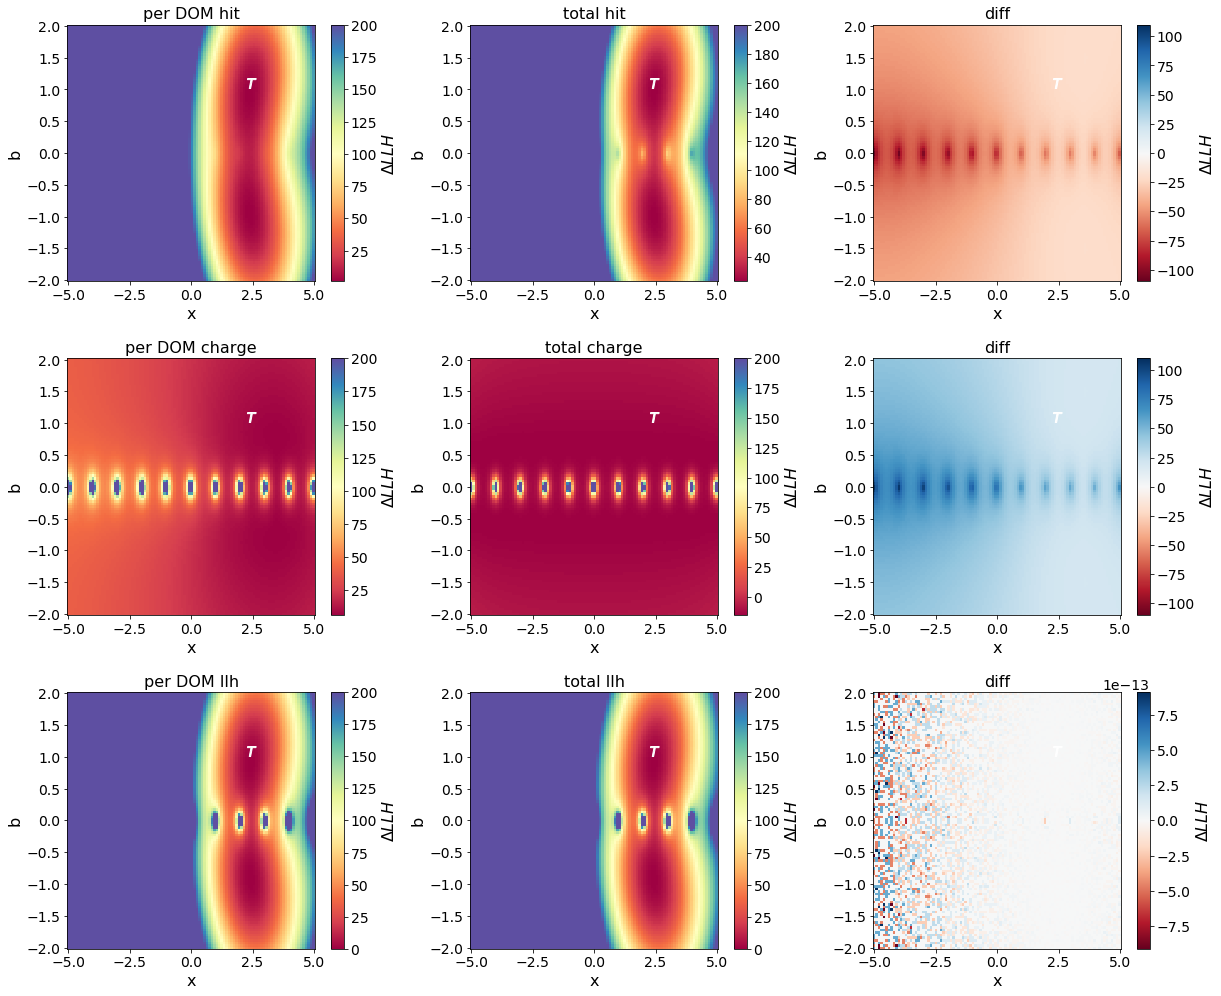

In [15]:
fig, ax = plt.subplots(3, 3, figsize=(20,17))
plt.subplots_adjust(wspace=0.3, hspace=0.3)

plot_diff(g['dom_hit_term'], g['total_charge_hit_terms'], axes=ax[0], title_a='per DOM hit', title_b='total hit', vmax=200)
plot_diff(g['dom_charge_terms'], g['total_charge_terms'], axes=ax[1], title_a='per DOM charge', title_b='total charge', vmax=200)
plot_diff(g['dom_llh'], g['total_charge_llh'], axes=ax[2], title_a='per DOM llh', title_b='total llh', vmax=200)

plot_truth(ax, example_x_src, example_b_src)

# Train NNs

In [16]:
#!rm events.pkl

In [17]:
%%time
fname = 'events.pkl'
if os.path.isfile(fname):
    with open(fname, 'rb') as file:
        events = pickle.load(file)
else:
    # generate some MC (it's very slow right now....about 15min for 1e5, but I don't mind)
    events = toy_experiment.generate_events(int(1e5), N_lims=(0, 20))
    with open(fname, 'wb') as file:
        pickle.dump(events, file, protocol=pickle.HIGHEST_PROTOCOL)

CPU times: user 430 ms, sys: 132 ms, total: 562 ms
Wall time: 562 ms


In [18]:
mc, truth = events

In [19]:
hitnet = SimpleNamespace()
chargenet = SimpleNamespace()

Prepare Data for NN

In [20]:
chargenet.x = []
hitnet.x = []
n_hits_per_event = []
for item in mc:
    chargenet.x.append(item[0])
    hitnet.x.append(item[1])
    n_hits_per_event.append(item[1].shape[0])

In [21]:
chargenet.x = np.concatenate(chargenet.x)
hitnet.x = np.concatenate(hitnet.x)
n_hits_per_event = np.array(n_hits_per_event)

In [22]:
chargenet.t = np.repeat(truth, len(toy_experiment.detector_xs), axis=0)
hitnet.t = np.repeat(truth, n_hits_per_event, axis=0)

In [23]:
assert chargenet.x.shape == chargenet.t.shape
assert hitnet.x.shape == hitnet.t.shape

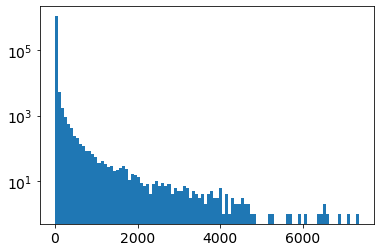

In [24]:
plt.hist(chargenet.x[:,0], bins=100)
plt.gca().set_yscale('log')

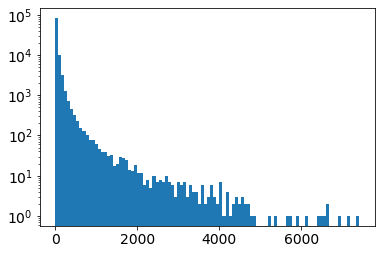

In [25]:
plt.hist(n_hits_per_event, bins=100)
plt.gca().set_yscale('log')

In [26]:
def get_dataset(x, t, shuffle_block_size=2**15, batch_size=2**12, test=False):
        '''
        get a tensorflow dataset for likelihood approximation
        
        Parameters:
        -----------
        x : ndarray
            observations
        t : ndarray
            parameters        
        shuffle_block_size : int
            block size over which to shuffle, should be multiple of batch_size
        batch_size : int
        test : bool
            no shuffling, prefetching and caching
        
        Returns:
        --------
        
        tf.data.Dataset
            with structure ((x, t), y) for training
        
        '''
        
        N = x.shape[0]
        assert t.shape[0] == N
        
        d_x = tf.data.Dataset.from_tensor_slices(x)
        d_t = tf.data.Dataset.from_tensor_slices(t)

        d_true_labels = tf.data.Dataset.from_tensor_slices(np.ones((N, 1), dtype=x.dtype))
        d_false_labels = tf.data.Dataset.from_tensor_slices(np.zeros((N, 1), dtype=x.dtype))

        d_xs = tf.data.Dataset.from_tensor_slices([d_x, d_x]).interleave(lambda x : x)
        d_ts = tf.data.Dataset.from_tensor_slices([d_t, d_t.shuffle(shuffle_block_size)]).interleave(lambda x : x)
        d_ys = tf.data.Dataset.from_tensor_slices([d_true_labels, d_false_labels]).interleave(lambda x : x)
        
        
        dataset = tf.data.Dataset.zip((tf.data.Dataset.zip((d_xs, d_ts)), d_ys))
  
        return dataset.batch(batch_size)

## DOM charge Net

In [27]:
chargenet.x_train, chargenet.x_test, chargenet.t_train, chargenet.t_test = train_test_split(chargenet.x, chargenet.t, test_size=0.2, random_state=42)

In [28]:
chargenet.d_train = get_dataset(chargenet.x_train, chargenet.t_train)
chargenet.d_test = get_dataset(chargenet.x_test, chargenet.t_test, test=True)

In [29]:
class trafo(tf.keras.layers.Layer):

    def call(self, charges, theta):
        r2 = tf.math.square(theta[:,0] - charges[:,1]) + tf.math.square(theta[:,1])
        out = tf.stack([
                 charges[:,0],
                 charges[:,1],
                 charges[:,2],
                 r2,
                 theta[:,0],
                 theta[:,1],
                 theta[:,2]
                ],
                axis=1
                )    
        return out
chargenet.trafo = trafo

In [31]:
#activation=tfa.activations.mish
activation='relu'

x_input = tf.keras.Input(shape=(chargenet.x_train.shape[1],))
t_input = tf.keras.Input(shape=(chargenet.t_train.shape[1],))

h = chargenet.trafo()(x_input, t_input)

h = tf.keras.layers.Dense(32, activation=activation)(h)
h = tf.keras.layers.Dropout(0.01)(h)

h = tf.keras.layers.Dense(64, activation=activation)(h)
h = tf.keras.layers.Dropout(0.01)(h)

h = tf.keras.layers.Dense(128, activation=activation)(h)
h = tf.keras.layers.Dropout(0.01)(h)

h = tf.keras.layers.Dense(64, activation=activation)(h)
h = tf.keras.layers.Dropout(0.01)(h)

h = tf.keras.layers.Dense(32, activation=activation)(h)
h = tf.keras.layers.Dropout(0.01)(h)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(h)

chargenet.model = tf.keras.Model(inputs=[x_input, t_input], outputs=outputs)
chargenet.model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 3)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 3)]          0                                            
__________________________________________________________________________________________________
trafo (trafo)                   (None, 7)            0           input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 32)           256         trafo[0][0]                      
______________________________________________________________________________________________

In [32]:
optimizer = tf.keras.optimizers.Adam(0.001)
chargenet.model.compile(loss='binary_crossentropy', optimizer=optimizer)

In [33]:
chargenet.hist = chargenet.model.fit(chargenet.d_train, epochs=10, verbose=1, validation_data=chargenet.d_test)

Epoch 1/10
430/430 [==============================] - 10s 22ms/step - loss: 0.5754 - val_loss: 0.5296
Epoch 2/10
430/430 [==============================] - 9s 21ms/step - loss: 0.5321 - val_loss: 0.5223
Epoch 3/10
430/430 [==============================] - 9s 21ms/step - loss: 0.5279 - val_loss: 0.5221
Epoch 4/10
430/430 [==============================] - 9s 21ms/step - loss: 0.5256 - val_loss: 0.5202
Epoch 5/10
430/430 [==============================] - 9s 21ms/step - loss: 0.5242 - val_loss: 0.5200
Epoch 6/10
430/430 [==============================] - 9s 21ms/step - loss: 0.5230 - val_loss: 0.5183
Epoch 7/10
430/430 [==============================] - 9s 21ms/step - loss: 0.5225 - val_loss: 0.5193
Epoch 8/10
430/430 [==============================] - 9s 21ms/step - loss: 0.5213 - val_loss: 0.5187
Epoch 9/10
430/430 [==============================] - 9s 22ms/step - loss: 0.5224 - val_loss: 0.5187
Epoch 10/10
430/430 [==============================] - 9s 21ms/step - loss: 0.5212 - val_l

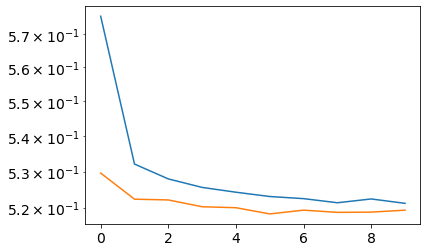

In [34]:
plt.plot(chargenet.model.history.history['loss'])
plt.plot(chargenet.model.history.history['val_loss'])
plt.gca().set_yscale('log')

In [36]:
chargenet.llh = tf.keras.models.clone_model(chargenet.model)
chargenet.llh.set_weights(chargenet.model.get_weights())
chargenet.llh.layers[-1].activation = tf.keras.activations.linear
chargenet.llh.compile()

In [37]:
# some nasty gymnastics to get the NN inputs for the grid scan
chargenet.tt = np.vstack([g.get_array('x', flat=True), g.get_array('b', flat=True), np.ones(np.prod(g.shape)) * example_N_src]).T
chargenet.tts = np.repeat(chargenet.tt, len(toy_experiment.detector_xs), axis=0)

chargenet.xxs = np.repeat(test_event[0][np.newaxis,:, :], np.prod(g.shape), axis=0)
chargenet.xxs = chargenet.xxs.reshape(-1, 3)

In [38]:
chargenet.llhs = chargenet.llh.predict([chargenet.xxs, chargenet.tts])    

In [39]:
g['charge_llh'] = -np.sum(chargenet.llhs.reshape(-1, len(toy_experiment.detector_xs)), axis=1).reshape(g.shape)
g['charge_llh'] -= np.min(g['charge_llh'])

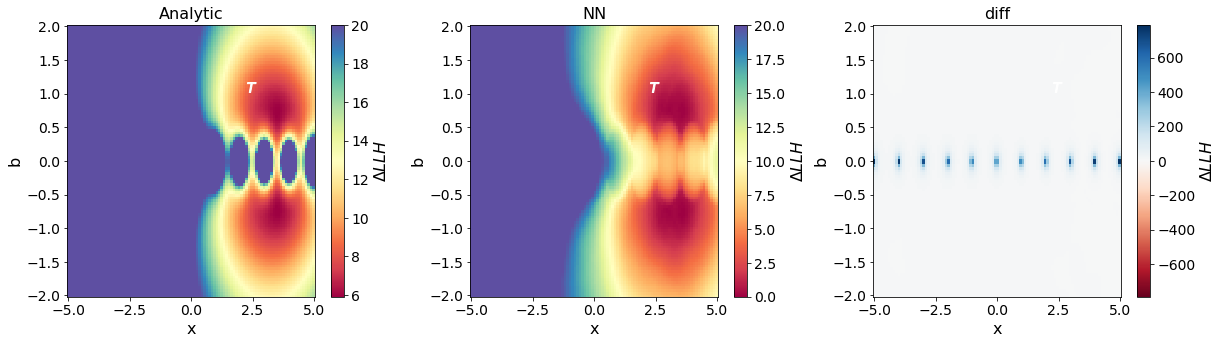

In [40]:
fig, ax = plt.subplots(1, 3, figsize=(20,5))
plt.subplots_adjust(wspace=0.3)

plot_diff(g['dom_charge_terms'], g['charge_llh'], title_a='Analytic', title_b='NN', vmax=20, axes=ax)
plot_truth(ax, example_x_src, example_b_src)

## DOM hit Net

In [41]:
hitnet.x_train, hitnet.x_test, hitnet.t_train, hitnet.t_test = train_test_split(hitnet.x, hitnet.t, test_size=0.2, random_state=42)

In [42]:
hitnet.d_train = get_dataset(hitnet.x_train, hitnet.t_train)
hitnet.d_test = get_dataset(hitnet.x_test, hitnet.t_test, test=True)

In [43]:
class trafo(tf.keras.layers.Layer):
    c = 0.3
    def call(self, hits, theta):
        r2 = tf.math.square(theta[:,0] - hits[:,1]) + tf.math.square(theta[:,1])
        r = tf.math.sqrt(r2)
        
        delta_t = hits[:,0] - r/self.c 
        
        out = tf.stack([
                 hits[:,0],
                 hits[:,1],
                 hits[:,2],
                 r,
                 delta_t,
                 theta[:,0],
                 theta[:,1],
                 theta[:,2]
                ],
                axis=1
                )    
        return out
hitnet.trafo = trafo

In [44]:
#activation=tfa.activations.mish
activation='relu'

x_input = tf.keras.Input(shape=(hitnet.x_train.shape[1],))
t_input = tf.keras.Input(shape=(hitnet.t_train.shape[1],))

h = hitnet.trafo()(x_input, t_input)

h = tf.keras.layers.Dense(32, activation=activation)(h)
h = tf.keras.layers.Dropout(0.01)(h)

h = tf.keras.layers.Dense(64, activation=activation)(h)
h = tf.keras.layers.Dropout(0.01)(h)

#h = tf.keras.layers.Dense(128, activation=activation)(h)
#h = tf.keras.layers.Dropout(0.01)(h)

#h = tf.keras.layers.Dense(64, activation=activation)(h)
#h = tf.keras.layers.Dropout(0.01)(h)

h = tf.keras.layers.Dense(32, activation=activation)(h)
h = tf.keras.layers.Dropout(0.01)(h)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(h)

hitnet.model = tf.keras.Model(inputs=[x_input, t_input], outputs=outputs)
hitnet.model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 3)]          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 3)]          0                                            
__________________________________________________________________________________________________
trafo_1 (trafo)                 (None, 8)            0           input_3[0][0]                    
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 32)           288         trafo_1[0][0]                    
____________________________________________________________________________________________

In [45]:
optimizer = tf.keras.optimizers.Adam(0.001)
hitnet.model.compile(loss='binary_crossentropy', optimizer=optimizer)

In [46]:
hist = hitnet.model.fit(hitnet.d_train, epochs=4, verbose=1, validation_data=hitnet.d_test)

Epoch 1/10
2441/2441 [==============================] - 53s 22ms/step - loss: 0.2211 - val_loss: 0.1986
Epoch 2/10
2441/2441 [==============================] - 49s 20ms/step - loss: 0.1995 - val_loss: 0.1975
Epoch 3/10
2441/2441 [==============================] - 50s 21ms/step - loss: 0.1980 - val_loss: 0.1972
Epoch 4/10
2441/2441 [==============================] - ETA: 0s - loss: 0.1975

KeyboardInterrupt: 

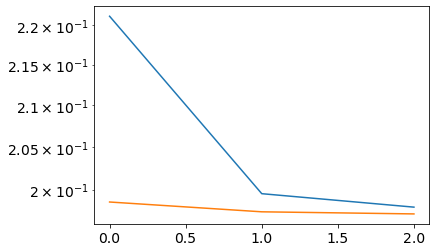

In [47]:
plt.plot(hitnet.model.history.history['loss'])
plt.plot(hitnet.model.history.history['val_loss'])
plt.gca().set_yscale('log')

In [48]:
hitnet.llh = tf.keras.models.clone_model(hitnet.model)
hitnet.llh.set_weights(hitnet.model.get_weights())
hitnet.llh.layers[-1].activation = tf.keras.activations.linear
hitnet.llh.compile()

In [49]:
# some nasty gymnastics to get the NN inputs for the grid scan
hitnet.tt = np.vstack([g.get_array('x', flat=True), g.get_array('b', flat=True), np.ones(np.prod(g.shape)) * example_N_src]).T
hitnet.tts = np.repeat(hitnet.tt, test_event[1].shape[0], axis=0)
hitnet.xxs = np.repeat(test_event[1][np.newaxis,:, :], np.prod(g.shape), axis=0)
hitnet.xxs = hitnet.xxs.reshape(-1, 3)

In [50]:
hitnet.llhs = hitnet.llh.predict([hitnet.xxs, hitnet.tts])    

In [51]:
g['hit_llh'] = -np.sum(hitnet.llhs.reshape(-1, test_event[1].shape[0]), axis=1).reshape(g.shape)
g['hit_llh'] -= np.min(g['hit_llh'])

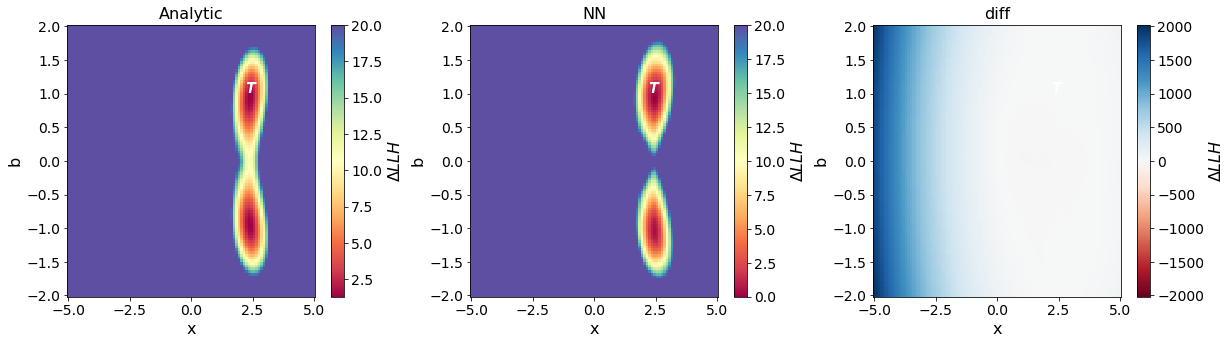

In [52]:
fig, ax = plt.subplots(1, 3, figsize=(20,5))
plt.subplots_adjust(wspace=0.3)

plot_diff(g['dom_hit_term'], g['hit_llh'], title_a='Analytic', title_b='NN', vmax=20, axes=ax)
plot_truth(ax, example_x_src, example_b_src)

In [53]:
g['llh'] = g['dom_llh'] + g['hit_llh']
g['llh'] -= np.min(g['llh'])

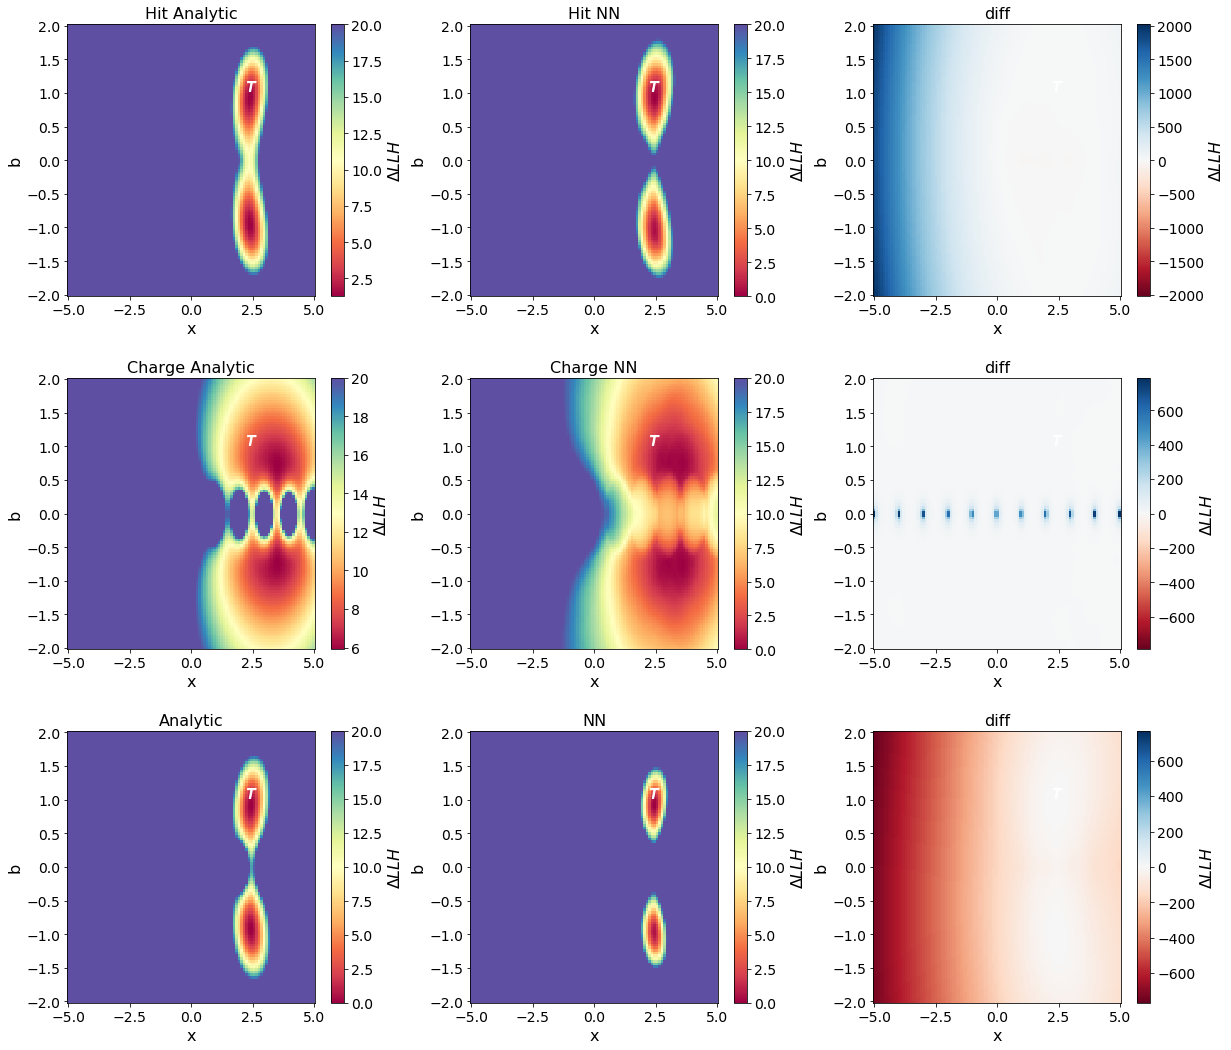

In [54]:
fig, ax = plt.subplots(3, 3, figsize=(20,18))
plt.subplots_adjust(wspace=0.3, hspace=0.3)

# Zoom in
#grid_to_plot = g[example_x_src-0.5:example_x_src+0.5, example_b_src-0.5:example_b_src+0.5]

grid_to_plot = g

plot_diff(grid_to_plot['dom_hit_term'], grid_to_plot['hit_llh'], title_a='Hit Analytic', title_b='Hit NN', vmax=20, axes=ax[0])
plot_diff(grid_to_plot['dom_charge_terms'], grid_to_plot['charge_llh'], title_a='Charge Analytic', title_b='Charge NN', vmax=20, axes=ax[1])
plot_diff(grid_to_plot['dom_llh'], grid_to_plot['llh'], title_a='Analytic', title_b='NN', vmax=20, axes=ax[2])

plot_truth(ax, example_x_src, example_b_src)

#plt.savefig('NNtest.png', bbox_inches='tight')